<a href="https://colab.research.google.com/github/dc3347/CompAspectsofRobotics/blob/main/Robotics_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import math
import numpy as np
import matplotlib.pyplot as plt

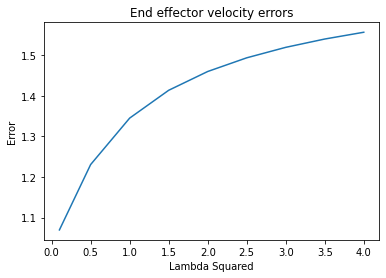

In [124]:
# Problem 2c

# Damped Least Squares Pseudoinverse
def DLS_pinv(A,lambd_sq,q_end):
  # The Jacobian can be writted in terms of its SVD
  u,s,vT = np.linalg.svd(A)
  vT = vT[:len(s),:]
  
  # DLS pseudoinverse J^+ = VDU^T 
  s += np.array([lambd_sq]*len(s)) # s is sigma
  D = np.divide(s,s**2+lambd_sq) # D is a n x 6 diag matrix with d_i = sigma/(sigma^2+lambda^2)
  v = vT.T
  Jv = np.dot(np.dot(v,np.diag(D)),u.T)

  # q = J^+ * (1,1,1)
  q = Jv@q_end
  '''
  j =fk_jac(q_end)
  Jv = j.T@np.linalg.inv(j@j.T + lambd_sq@np.identity(4))
  q = Jv@q_end
  '''
  return q


N=20
xD = np.array([1,1,1]) # desired end effector velocity
lambd_sq = [0.1,0.5,1,1.5,2,2.5,3,3.5,4]

# A is the Jacobian for (x, y, z)
A = np.array([[-1.732,2.598,0],
             [-1,1.5,0],
             [0,0,1]])

fig, ax1 = plt.subplots()
y=[]
for lambd in lambd_sq:
  trace = DLS_pinv(A,lambd,xD)
  err = np.linalg.norm(trace-xD)
  y.append(err)
  
ax1.plot(lambd_sq,y)
ax1.set_xlabel('Lambda Squared')
ax1.set_ylabel('Error')
ax1.set_title('End effector velocity errors')

plt.show()

In [125]:
# Problem 3

T_d = np.array([[-0.014,0.991,0.135],
                [-0.1,0.136,0.986],
                [0.995,0,0.101]])

def fk_all(q):

  fk = np.array([[np.cos(q[0])*np.cos(q[1]), -np.sin(q[0]), np.cos(q[0])*np.sin(q[1]), np.cos(q[0])*np.sin(q[1])*q[2]-np.sin(q[0])],
                 [np.sin(q[0])*np.cos(q[1]),  np.cos(q[0]), np.sin(q[0])*np.sin(q[1]), np.sin(q[0])*np.sin(q[1])*q[2]+np.cos(q[0])],
                 [-np.sin(q[1]), 0, np.cos(q[1]), np.cos(q[1])*q[2]],
                 [0,0,0,1]])
  return fk

def fk_jac(q):
  jac = np.array([[-np.cos(q[0])-q[2]*np.sin(q[0])*np.sin(q[1]), q[2]*np.cos(q[0])*np.cos(q[1]), np.cos(q[0])*np.sin(q[1])],
                  [-np.sin(q[0])+q[2]*np.cos(q[0])*np.sin(q[1]), q[2]*np.sin(q[0])*np.cos(q[1]), np.sin(q[0])*np.sin(q[1])],
                  [0, -q[2]*np.sin(q[1]), np.cos(q[1])],
                  [0, -np.sin(q[0]), 0],
                  [0, np.cos(q[0]), 0],
                  [1, 0, 0]])
  return jac


def damped_newton(q0,N,gamma):
  trace = [q0]
  errors = []

  for i in range(N):
    q = trace[-1]
    FK = fk_all(q)
  
    j =fk_jac(q)
    J_inv = j.T@np.linalg.inv(j@j.T + gamma**2*np.eye(6))

    o_err = xD-FK[:3,3]
    theta_err = (1/2)*(np.cross(FK[:3,0], T_d[:,0])+np.cross(FK[:3,1], T_d[:,1])+np.cross(FK[:3,2], T_d[:,2]))
    
    err = np.concatenate((o_err,theta_err))
    errors.append(np.linalg.norm(err))

    dq = J_inv@err
    q1 = q+dq
    trace.append(q1)

  return trace, errors


def gradient_descent(q0, N, gamma):
  trace = [q0]
  errors = []

  for i in range(N):
    q = trace[-1]
    FK = fk_all(q)
 
    o_err = xD-FK[:3,3]
    theta_err = (1/2)*(np.cross(FK[:3,0], T_d[:,0])+np.cross(FK[:3,1], T_d[:,1])+np.cross(FK[:3,2], T_d[:,2]))
    
    err = np.concatenate((o_err,theta_err))
    errors.append(np.linalg.norm(err))
    J_trans = fk_jac(q).T

    dq = np.dot(J_trans,err)
    q1 = q+alpha*dq
    trace.append(q1)

  return trace, errors



0.5363032797865634


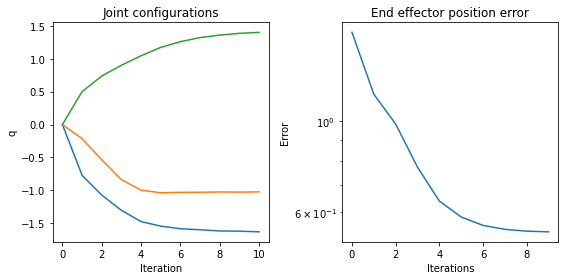

In [126]:
q0 = np.array([0,0,0]) # starting configuration
xD = np.array([1,1,1]) #xD is the target configuration
gamma = 0.01
alpha = 0.5

#trace, err = damped_newton(q0, 10, gamma)
trace, err = gradient_descent(q0, 10, alpha)

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(141)
ax1.plot(range(len(trace)), [q1 for (q1,q2,q3) in trace])
ax1.plot(range(len(trace)), [q2 for (q1,q2,q3) in trace])
ax1.plot(range(len(trace)), [q3 for (q1,q2,q3) in trace])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('q')
ax1.set_title('Joint configurations') # joint angles plotted over iterations

ax2 = fig.add_subplot(142)
ax2.semilogy(range(len(err)),err)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Error')
ax2.set_title('End effector position error')
print(err[-1])
fig.tight_layout()
plt.show()

In [127]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 50)                200       
_________________________________________________________________
dense_55 (Dense)             (None, 3)                 153       
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 0s 7ms/step - loss: 2.6915 - val_loss: 1.6626
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 1.4777 - val_loss: 0.8332
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 0.7211 - val_loss: 0.3943
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 0.3263 - val_loss: 0.1874
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: 0.1686 - val_loss: 0.1020
Epoch 6/10
25/25 [=========

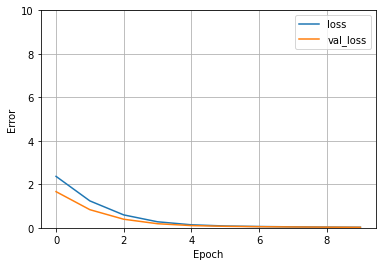

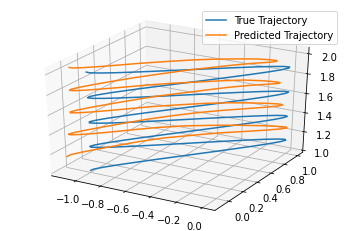

In [128]:
# Problem 4
# Given end effector pose, network should return the joint variables 

# 1. Generate data for kinematics problem (training data)
# generate 1000 points of theta 1
theta_1 = np.random.uniform(-math.pi, math.pi, 1000)

# generate 1000 points of theta 2
theta_2 = np.random.uniform(-math.pi, math.pi, 1000)

# generate 1000 points of d3
d_3 = np.random.uniform(0, 3, 1000)

# process the samples
#samples=[]
samples = np.empty((1000,3))
for i in range(len(theta_1)):
  #samples.append([theta_1[i],theta_2[i],d_3[i]])
  samples[i][0]=theta_1[i]
  samples[i][1]=theta_2[i]
  samples[i][2]=d_3[i]

# put samples through fk_all to generate training data
dataset = np.empty((1000,3))
for i in range(len(samples)):
  dataset[i][0]=theta_1[i]
  dataset[i][1]=theta_2[i]
  dataset[i][2]=d_3[i]

# 2. Build a network using Keras library
model = tf.keras.Sequential([
    layers.Input(shape=(3,)), #input layer with 3 neurons
    layers.Dense(50, activation='relu'), #one nonlinear hidden layer with 50 neuronos, set input shape 
    layers.Dense(3) #output layer with 3 neurons
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)
model.summary()

# 3. Feed training data into the network
output = model.fit(
    x=dataset,
    y=samples,
    epochs=10,
    validation_split=0.2
)

# 4. Plot both val_loss and loss
def plot_loss(output):
  plt.plot(output.history['loss'], label='loss')
  plt.plot(output.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(output)

# 5. Use this model now as a predictor for the inverse kinematics, should predict 'samples'
# output is joint configs
fig = plt.figure()
ax = plt.axes(projection='3d')
K = 100 #points
traj = np.zeros((K,3))
traj[:,0] = -np.cos(np.linspace(0,4*np.pi,num=100))**2
traj[:,1] = np.sin(np.linspace(0,4*np.pi,num=100))**2
traj[:,2] = np.linspace(1,2,num=100)
ax.plot3D(traj[:,0], traj[:,1], traj[:,2])

new_traj = model.predict(
    x=traj,#dataset,
    batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)
ax.plot3D(new_traj[:,0], new_traj[:,1], new_traj[:,2])
ax.legend(["True Trajectory", "Predicted Trajectory"])

